In [214]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [215]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "4"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

linkediniterationNumber = "2"
linkedinRootPath = sourceDataFolder + r"\main\linkedin\iteration-" + linkediniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-merged-main"
logsFolder = "4-logs"

dataVisualizationTopLimit = 15

In [216]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [217]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    
  ]
  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [218]:
def getEncodingBumeran(file, stringLog):
  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [219]:
def getEncodingLinkedin(file, stringLog):
  encoding = "windows-1256"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1256") as f:
        if "charset=windows-1256" in f.read():
          encoding = 'windows-1256'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [220]:
def getCandidateBumeran(file, encoding, stringLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data
      
      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      color = "#008599" if (postulationDate <= datetime.datetime(2020,6,11,12,5,0)) else "#E90066"

      # Nombre del perfil
      candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + color) })[0].text))

      # Nombre del postulante
      rawcandidateName = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[0].text # El split join tambien quita saltos de línea
      candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(rawcandidateName))

      # Pais de residencia
      tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[2].text
      if tagResidenceCountry.find(",") == -1:
        candidateData["residenceCountry"] = ""
      else:
        rawResidenceCountry = tagResidenceCountry[0:tagResidenceCountry.find(",")]
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(rawResidenceCountry))
      """
      # Canal
      candidateData["channel"] = "Bumeran"

      # Obteniendo todas las etiquetas principales
      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)

      # Experiencia laboral
      workExperienceIndex = getChildIndex(mainChildTags, "Experiencia laboral", color)
      educationIndex = getChildIndex(mainChildTags, "Educación", color)

      if workExperienceIndex and educationIndex:
        workExperienceTags = mainChildTags[workExperienceIndex+2:educationIndex]
        candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[0].find_all("b")[0].text))
        candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[1].find_all("b")[0].text))

        # Hay un caso que tiene span ya de por si en las experiencias laborales, el html 22, revisar
        daysOfExperience = 0
        for index in range(0, len(workExperienceTags), 2):
          startDate = datetime.datetime.strptime(parseLineBreaksAndAccents(workExperienceTags[index].text)[0: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")] , "%d-%m-%Y")
          endDateText = parseLineBreaksAndAccents(workExperienceTags[index].text)[parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")+3: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" | ")]
          endDate = datetime.datetime.strptime(endDateText, "%d-%m-%Y") if endDateText != "Presente" else datetime.datetime.strptime(rawPostulationDate, "%A, %B %d, %Y %I:%M %p")
          daysOfExperience = daysOfExperience + (endDate - startDate).days
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)
      else:
        candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
        candidateData["yearsOfExperience"] = 0
        candidateData["worksNumber"] = 0

      # Carrera profesional (última alcanzada)
      educationIndex = getChildIndex(mainChildTags, "Educación", color)
      informaticsIndex = getChildIndex(mainChildTags, "Informática", color)

      if educationIndex and informaticsIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        educationTags = mainChildTags[educationIndex+2:informaticsIndex]

        boldTags0 = educationTags[0].find_all("b")
        if len(boldTags0) == 0:
          candidateData["studyCenter"] = ""
          candidateData["careerField"] = ""
        elif len(boldTags0) == 1:
          #print("GA")
          if (parseLineBreaksAndAccents(educationTags[0].text).find(",") - parseLineBreaksAndAccents(educationTags[0].text).find(" | ") == 3):
            candidateData["studyCenter"] = ""
            candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(boldTags0[0].text.strip()))
          else:
            candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(boldTags0[0].text.strip()))
            candidateData["careerField"] = ""
        else:
          #print("AG")
          #print(educationTags[0].find_all("b")[0])
          candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(boldTags0[0].text.strip()))
          candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(boldTags0[1].text.strip()))
        
        haveBoldTags1 = True if len(educationTags[1].find_all("b")) > 0 else False
        #if len(boldTags1) == 1:
        tempTags = educationTags[1].find_all("span")
        #print(tempTags[1:])
        statusDegreeIndex = next(((index+1 if haveBoldTags1 else index) for index, x in enumerate( tempTags[1:] if haveBoldTags1 else tempTags ) if "," in x.text), None)
        #print([x.text for index, x in enumerate(tempTags[1:])])
        #print(statusDegreeIndex)
        
        if statusDegreeIndex is not None:
          candidateData["careerStatus"] = parseNames(parseLineBreaksAndAccents(educationTags[1].find_all("span")[statusDegreeIndex].text.split(",")[1].strip()))
          candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(educationTags[1].find_all("span")[statusDegreeIndex].text.split(",")[2].strip()[:-1]))
          candidateData["studiesNumber"] = int(len(educationTags)/2)
        else:
          candidateData["careerStatus"] = candidateData["careerDegree"] = ""
          candidateData["studiesNumber"] = 0
      else:
        candidateData["studyCenter"] = candidateData["careerField"] = candidateData["careerStatus"] = candidateData["careerDegree"] = ""
        candidateData["studiesNumber"] = 0
      #print(file)
      #print(candidateData["careerStatus"])
      #print(candidateData["careerDegree"])
      #print()

      # Habilidades técnicas
      informaticsIndex = getChildIndex(mainChildTags, "Informática", color)
      languageIndex = getChildIndex(mainChildTags, "Idiomas", color)

      if informaticsIndex and languageIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        technicalSkillsTags = mainChildTags[informaticsIndex+2:languageIndex][0].find_all("span")
        candidateData["technicalSkills"] = int(len(technicalSkillsTags)/4)

      else:
        candidateData["technicalSkills"] = 0

      # Falta habilidades blandas

      # Lenguajes
      languageIndex = getChildIndex(mainChildTags, "Idiomas", color)
      otherKnowledgesIndex = getChildIndex(mainChildTags, "Otros Conocimientos", color)

      if languageIndex and otherKnowledgesIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        languagesTags = mainChildTags[languageIndex+2:otherKnowledgesIndex][0].find_all("span")
        candidateData["languages"] = int(len(languagesTags)/7)

      else:
        candidateData["languages"] = 1

      # Otros conocimientos
      otherKnowledgesIndex = getChildIndex(mainChildTags, "Otros Conocimientos", color)
      endIndex = len(mainChildTags)-1

      if languageIndex and otherKnowledgesIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        otherKnowledgesTags = mainChildTags[otherKnowledgesIndex+2:endIndex][0].find_all("span")
        candidateData["anotherSkills"] = int(len(otherKnowledgesTags)/3)
      else:
        candidateData["anotherSkills"] = 0

      candidateData["references"] = 0

      # Salario pretendido
      tagsSalary = [index for index, tag in enumerate(soup.find_all("span")) if "Sueldo pretendido" in tag.text]
      if len(tagsSalary) > 0:
        rawSalary = soup.find_all("span")[tagsSalary[0]+1].text
        candidateData["salary"] = int(float(parseLineBreaksAndAccents(" ".join(rawSalary.split()))[1:].title()))
      else:
        candidateData["salary"] = 0"""

  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass

  return candidateData, stringLog

In [221]:
def getCandidateLinkedin(file, encoding, stringLog):
  candidateData = {}

  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      
      soup = BeautifulSoup(myFile.read(), "lxml")

      spanBlack = soup.find_all("span", {"style": "color:black"})
      if len(spanBlack) > 4:
        postulationDate = datetime.datetime.strptime(spanBlack[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        postulationDate = datetime.datetime.strptime(spanBlack2[3].text, "%A, %B %d, %Y %I:%M %p")

      # Cambiar el lugar de donde se saca, sacarlo del body no del asunto
      if len(spanBlack) > 7:
        rawProfileName = parseLineBreaksAndAccents(spanBlack[7].text)
      else:
        spanBlack2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawProfileName = parseLineBreaksAndAccents(spanBlack2[7].text)

      startIndexProfileName = rawProfileName.find(": ")
      endIndexProfileName = rawProfileName.find(" from ")

      if postulationDate <= datetime.datetime(2022,9,23,2,15,0):
        
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "font-size:10.5pt;color:#262626;text-decoration:none;\n            text-underline:none"}).text))

        tempSpanTags = soup.find_all("span", {"style": 'font-size:9.0pt;font-family:\n            "Helvetica",sans-serif;color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        notHaveScreening = True if "Screening qualifications" not in str(soup) else False
        startTag = 15 if notHaveScreening else 16
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Skills matching your job" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]

        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              #spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span") Caso particular que no vale la pena
              #startSpanIndex = 0 if len(spanTags) == 2 else len(spanTags)-3
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[1])
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTag = findedTableTags[haveTag].find_all("tr")[1]
              pTags = trTag.find_all("p")
              for pTag in pTags:
                spanTag = parseLineBreaksAndAccents(pTag.find_all("span")[1].text)
                startDate = datetime.datetime.strptime(spanTag.split(" - ")[0], "%Y")
                endDate = datetime.datetime.strptime(spanTag.split(" - ")[1], "%Y")
                daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(pTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if(len(trTag.find_all("span"))>1):
                  if(len(trTags[index-1].find_all("span")) == 1):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(len(trTag.find_all("span"))==1):
                  studiesNumber = studiesNumber + 1
              
              #print(firstCenterWithDateIndex)
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1])
              #print(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", "))
              #print(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(", ")[1]))

              if firstCenterWithDateIndex != -1:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[1])) if len(tempTagArray) > 1 else ""
                candidateData["careerStatus"] = "En Curso" if ("Present" in parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[1].text)) else "Graduado"
                tempText = parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find_all("span")[0].text.split(",")[0])
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText)) if not tempText[0:4].isnumeric() else ""
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          elif index == 3:
            if haveTag is not None:
              skillsCounter = 0
              spanTags = findedTableTags[haveTag].find_all("tr")[1].find_all("span")
              for spanTag in spanTags:
                if "".join(spanTag["style"].split()) == 'font-size:10.5pt;font-family:"Helvetica",sans-serif;mso-fareast-font-family:"TimesNewRoman";color:#4D4D4D':
                  skillsCounter = skillsCounter + 1
              
              candidateData["technicalSkills"] = skillsCounter
            else:
              candidateData["technicalSkills"] = 0
            
            candidateData["languages"] = 1
            candidateData["anotherSkills"] = 0 if notHaveScreening else int(parseLineBreaksAndAccents(soup.find_all("table")[10].text)[parseLineBreaksAndAccents(soup.find_all("table")[10].text).find(": ")+2: parseLineBreaksAndAccents(soup.find_all("table")[10].text).find("/")])
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
        
      else:
        candidateData["postulationDate"] = postulationDate.strftime("%Y-%m-%d")

        candidateData["profileName"] = parseNames(parseLineBreaksAndAccents(rawProfileName[startIndexProfileName+1:endIndexProfileName]))

        candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(soup.find("span", {"style": "color:#0A66C2;text-decoration:none;text-underline:none"}).text))
        
        tempSpanTags = soup.find_all("span", {"style": 'font-size:10.5pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})
        existsCountry = True if len(tempSpanTags) > 1 else False
        candidateData["residenceCountry"] = parseNames(parseLineBreaksAndAccents(tempSpanTags[len(tempSpanTags)-1].text)) if existsCountry else ""

        candidateData["channel"] = "Linkedin"

        tableTags = soup.find_all("table")

        startTag = 14
        endTag = len(tableTags)-3
        findedTableTags = tableTags[startTag:endTag]

        haveTags = [None, None, None, None, None]

        for index, tag in enumerate(findedTableTags):
          haveTags[0] = index if "Current experience" in tag.text else haveTags[0]
          haveTags[1] = index if "Past experience" in tag.text else haveTags[1]
          haveTags[2] = index if "Education" in tag.text else haveTags[2]
          haveTags[3] = index if "Screening qualifications" in tag.text else haveTags[3]
          haveTags[4] = index if "Highlight" in tag.text else haveTags[4]
        
        for index, haveTag in enumerate(haveTags):
          if index == 0:
            if haveTag is not None:
              tempTrTags = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")
              #print(tempTrTags[1].find_all("span")[0].text)
              tempWorkCenter = tempTrTags[1] if len(tempTrTags) > 1 else ""
              candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(tempWorkCenter[0:tempWorkCenter.rfind(" - ")-4])) if tempWorkCenter != "" else ""
              candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].find_all("span")[0].text).split(" at ")[0])
            else:
              candidateData["lastWorkCenter"] = candidateData["lastWorkPosition"] = ""
          
          elif index == 1:
            if haveTag is not None:
              daysOfExperience = 0
              trTags = [x for x in findedTableTags[haveTag].find_all("tr") if x.find("span", {"style": 'font-size:9.0pt;font-family:"Helvetica",sans-serif;\n          color:#737373'})]
              #print(trTags)
              for trTag in trTags:
                #print(pTag.text)
                spanTag = parseLineBreaksAndAccents(trTag.find_all("span")[0].text)
                #print(spanTag)
                #print("".isnumeric())
                if spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")].isnumeric() and spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7].isnumeric():
                  startDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")-4:spanTag.rfind(" - ")], "%Y")
                  endDate = datetime.datetime.strptime(spanTag[spanTag.rfind(" - ")+3:spanTag.rfind(" - ")+7], "%Y")
                  daysOfExperience = daysOfExperience + (endDate - startDate).days
              candidateData["yearsOfExperience"] = int(daysOfExperience/365)
              candidateData["worksNumber"] = int(len(trTags))
            else:
              candidateData["yearsOfExperience"] = 0
              candidateData["worksNumber"] = 0

          elif index == 2:
            # No se tiene el careerStatus en linkedin
            if haveTag is not None:
              trTags = findedTableTags[haveTag].find_all("tr")[1:]
              #print(trTags[0])
              firstCenterWithDateIndex = -1
              studiesNumber = 0
              for index, trTag in enumerate(trTags):
                if " - " in parseLineBreaksAndAccents(trTag.text):
                  if " - " not in parseLineBreaksAndAccents(trTags[index-1].text):
                    if firstCenterWithDateIndex == -1:
                      firstCenterWithDateIndex = index-1
                if(" - " not in parseLineBreaksAndAccents(trTag.text)):
                  studiesNumber = studiesNumber + 1
              #print(firstCenterWithDateIndex)
              if firstCenterWithDateIndex != -1:
                #print("GA")
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex].text))
                tempTagArray = parseNames(parseLineBreaksAndAccents(trTags[firstCenterWithDateIndex+1].find("span").text))
                candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(tempTagArray[tempTagArray.find(", ")+1:tempTagArray.rfind(" - ")-4]))
                candidateData["careerStatus"] = "En Curso" if ("Present" in tempTagArray) else "Graduado"
                candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempTagArray[0:tempTagArray.find(", ")])) if tempTagArray.find(", ") != -1 else ""
                #print(candidateData)
              else:
                candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(trTags[0].text))
                candidateData["careerField"] = ""
                candidateData["careerStatus"] = ""
                candidateData["careerDegree"] = ""
              
              candidateData["studiesNumber"] = studiesNumber
            else:
              candidateData["studyCenter"] = ""
              candidateData["careerField"] = ""
              candidateData["careerStatus"] = ""
              candidateData["careerDegree"] = ""
              candidateData["studiesNumber"] = 0
          
          elif index == 3:
            if haveTag is not None:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = int(parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)[0])
            else:
              candidateData["technicalSkills"] = 0
              candidateData["languages"] = 1
              candidateData["anotherSkills"] = 0
            
          elif index == 4:
            if haveTag is not None:
              highlightText = parseLineBreaksAndAccents(findedTableTags[haveTag].find_all("tr")[1].text)
              #print(highlightText)
              isKnows = True if ("knows" in highlightText) else False
              #print(isKnows)
              isMoreThanTwo = True if ("others" in highlightText) else False
              if isKnows and isMoreThanTwo:
                candidateData["references"] = int(highlightText[highlightText.find(" and ")+5:highlightText.find(" others ")])
              elif isKnows and not isMoreThanTwo:
                candidateData["references"] = int(highlightText.count(" and ") + 1)
              else:
                candidateData["references"] = int(highlightText[highlightText.find(" hired ")+7:highlightText.find(" people ")])
            else:
              candidateData["references"] = 0
        candidateData["salary"] = 0
      
  except Exception as e:
    candidateData = {}
    print(file)
    stringLog = stringLog + str(file) + "\n"
    traceback.print_exc()
    stringLog = stringLog + traceback.format_exc() + "\n"
    print()
    stringLog = stringLog + "\n"
    pass
  
  return candidateData, stringLog

In [222]:
def iterateFiles(files, source):
  # Definiendo el log de errores
  stringLog = ""

  # Definiendo la data final de candidatos
  data = []
  
  # Iterando por cada archivo
  for file in files:
    # Obteniendo el encoding por cada archivo
    encoding, stringLog = getEncodingBumeran(file, stringLog) if source == 'bumeran' else getEncodingLinkedin(file, stringLog)

    # Obteniendo los datos por cada archivo
    candidate, stringLog = getCandidateBumeran(file, encoding, stringLog) if source == 'bumeran' else getCandidateLinkedin(file, encoding, stringLog)
    
    # Añadiendo los datos del candidato a la data final
    if (candidate):
      data.append(candidate)

  return data, stringLog

In [223]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath if source == "bumeran" else linkedinRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Iterando sobre los archivos, calculando la data y el log de error
  data, stringLog = iterateFiles(files, source)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(stringLog, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [224]:
def readAndWriteMergedMain(mainData):
  mainMergeddata = []
  for elem in mainData:
    if (elem):
      mainMergeddata.extend(elem)

  writeJson(mainMergeddata, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mainMergeddata, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mainMergeddata

In [225]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = ["profileName", "residenceCountry"]
  for column in columns:
    top10 = df[column].value_counts()[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-10 12:20:39.703397
Se inició el procesamiento
1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_22164\4037382718.py", line 34, in getCandidateBumeran
    tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[2].text
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_22164\4037382718.py", line 34, in getCandidateBumeran
    tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[2].text
IndexError: list index out of range


1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html



Traceback (most recent call last):
  File "C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_22164\4037382718.py", line 34, in getCandidateBumeran
    tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")[2].text
IndexError: list index out of range


Se terminó de procesar Bumeran
Se terminó de procesar Linkedin
Se terminó de unir la data principal
postulationDate     9794
profileName         9794
candidateName       9794
residenceCountry    9794
dtype: int64
Practicante De Recursos Humanos          962
Ejecutivo Comercial                      444
Gestor De Servicios De Ti                359
Asistente De Recursos Humanos            354
Jefe De Proyecto - Analytics & Ai        294
Asistente Social                         288
Analista Programador                     255
Programador .Net                         251
Practicante De Infrastructure & Cloud    220
Community Manger                         187
Desarrollador .Net                       181
Analista De Calidad                      177
Analista Funcional                       170
Ejecutivo(A) Comercial Ti                160
Jefe De Proyectos - Analytics & Ai       152
Name: profileName, dtype: int64


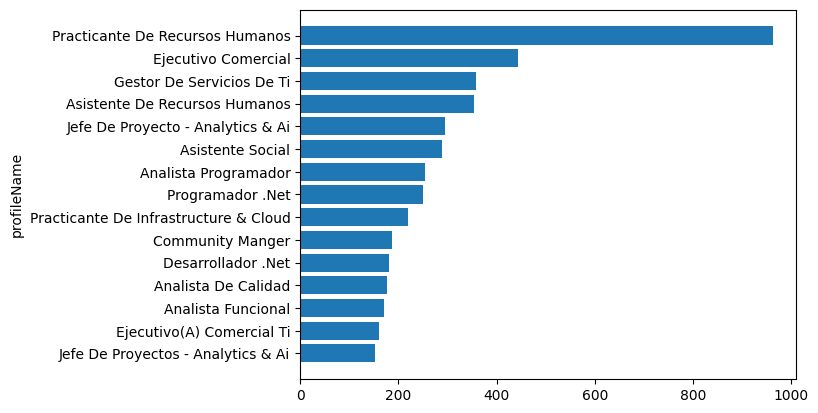

Fin: 2023-05-10 12:23:02.531262
Tiempo: 0:02:22.827865


In [226]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isLoadedLinkedin = True
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Leyendo o calculando linkedin
  linkedinData = readJson(os.path.join(intermFilesFolder, 'linkedin.json')) if isLoadedLinkedin else readAndWriteMain('linkedin')
  print("Se terminó de procesar Linkedin")

  # Uniendo la data principal (bumeran + linkedin)
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData, linkedinData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

if __name__ == "__main__":
  main()